In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import colors
import matplotlib.ticker as ticker
from scipy.stats import sem


import json
import sys
sys.path.append('..')
sys.path.append('../lib')
from lib import *
from lib.plotting import model_labels as labels
plt.style.use('../peptidome.mplstyle')
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

datadir = '../data/generated_data'
figdatadir = '../data/Figure Data'

## For original analyses and data derivation see https://github.com/andim/peptidome/tree/master/code/maxent

In [2]:
def compute_pc(arr):
    N = arr.shape[0]
    _, counts = np.unique(arr, return_counts=True,axis=0)
    return np.sum(counts * (counts - 1)) / (N * (N - 1))

In [ ]:
thinning_data = {}
proteome = 'Human'
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
NSTEPS = ["5418757","1e7"]
thinning = ["9", "10", "20","30","40","50","60","70","80","90","100"]
k=9



for n in NSTEPS:
    for t in thinning:
        sampler = {
            'pc' : {},
            'S': {},
            'N': {},
            'energies': {},
        }
        for model in models:
            print(f'model: {model}')
            
            if not os.path.exists(f"{datadir}/mcmc_thermo/{proteome}_{model}_{n}_{t}_entropy.csv"):
                print(f"{datadir}/mcmc_thermo/{proteome}_{model}_{n}_{t}_entropy.csv")
                continue
                
            energy = make_energy(np.load(f'{datadir}/{proteome}_{model}_k{k}_params.npz'))
            
            F = float(pd.read_csv(f"{datadir}/mcmc_thermo/{proteome}_{model}_{n}_{t}_entropy.csv",header=None, index_col=0).loc['F'].values[0])
            
            loglikelihood  = lambda seq: -energy(seq) + F
            
            matrix = load_matrix(f"{datadir}/mcmc_thermo/{proteome}_{model}_{n}_{t}_matrix.csv.gz")
        
            sampler['N'][model] = matrix.shape[0]
            coincidence_empirical = calc_coincidence_prob(matrix)
            sampler['pc'][model] = compute_pc(matrix)
            logp = np.array([loglikelihood(row) for row in matrix])
        
            energies = [energy(x) for x in matrix]
            # sampler['energies'][model] = energies
            sampler['S'][model] = np.mean(np.array(energies)) - F    

        thinning_data[f"Human_{n}_{t}"] = sampler

model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model: ncov
model: nskew
model: nskewfcov
model: independent
model

In [5]:
len(thinning_data)

22

In [6]:
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
s_data_small = {}
pc_data_small = {}
s_data_large = {}
pc_data_large = {}
for model in models:
    s_data_small[model] = {}
    pc_data_small[model] = {}
    s_data_large[model] = {}
    pc_data_large[model] = {}
for params, sampler in thinning_data.items():
    t_param = int(params.split("_")[-1])
    size = params.split("_")[1]
    s_dict = s_data_small if size == "5418757" else s_data_large
    pc_dict = pc_data_small if size == "5418757" else pc_data_large
    for model in models:
        try:
            s_dict[model][t_param]= sampler['S'][model]
            pc_dict[model][t_param]= sampler['pc'][model]
        except KeyError:
            s_dict[model][t_param] = np.nan 
            pc_dict[model][t_param]=np.nan
        

In [7]:
model_mapper = {
    "independent": "1st moment",
    "ncov": "2nd moment",
    "nskew": "3rd moment",
    "nskewfcov": "2-point"
}
k=9

color_mapper = {
    "independent": '#1f77b4',
    "ncov": "#ff7f0e",
    "nskew": "red",
    "nskewfcov": "black"
}

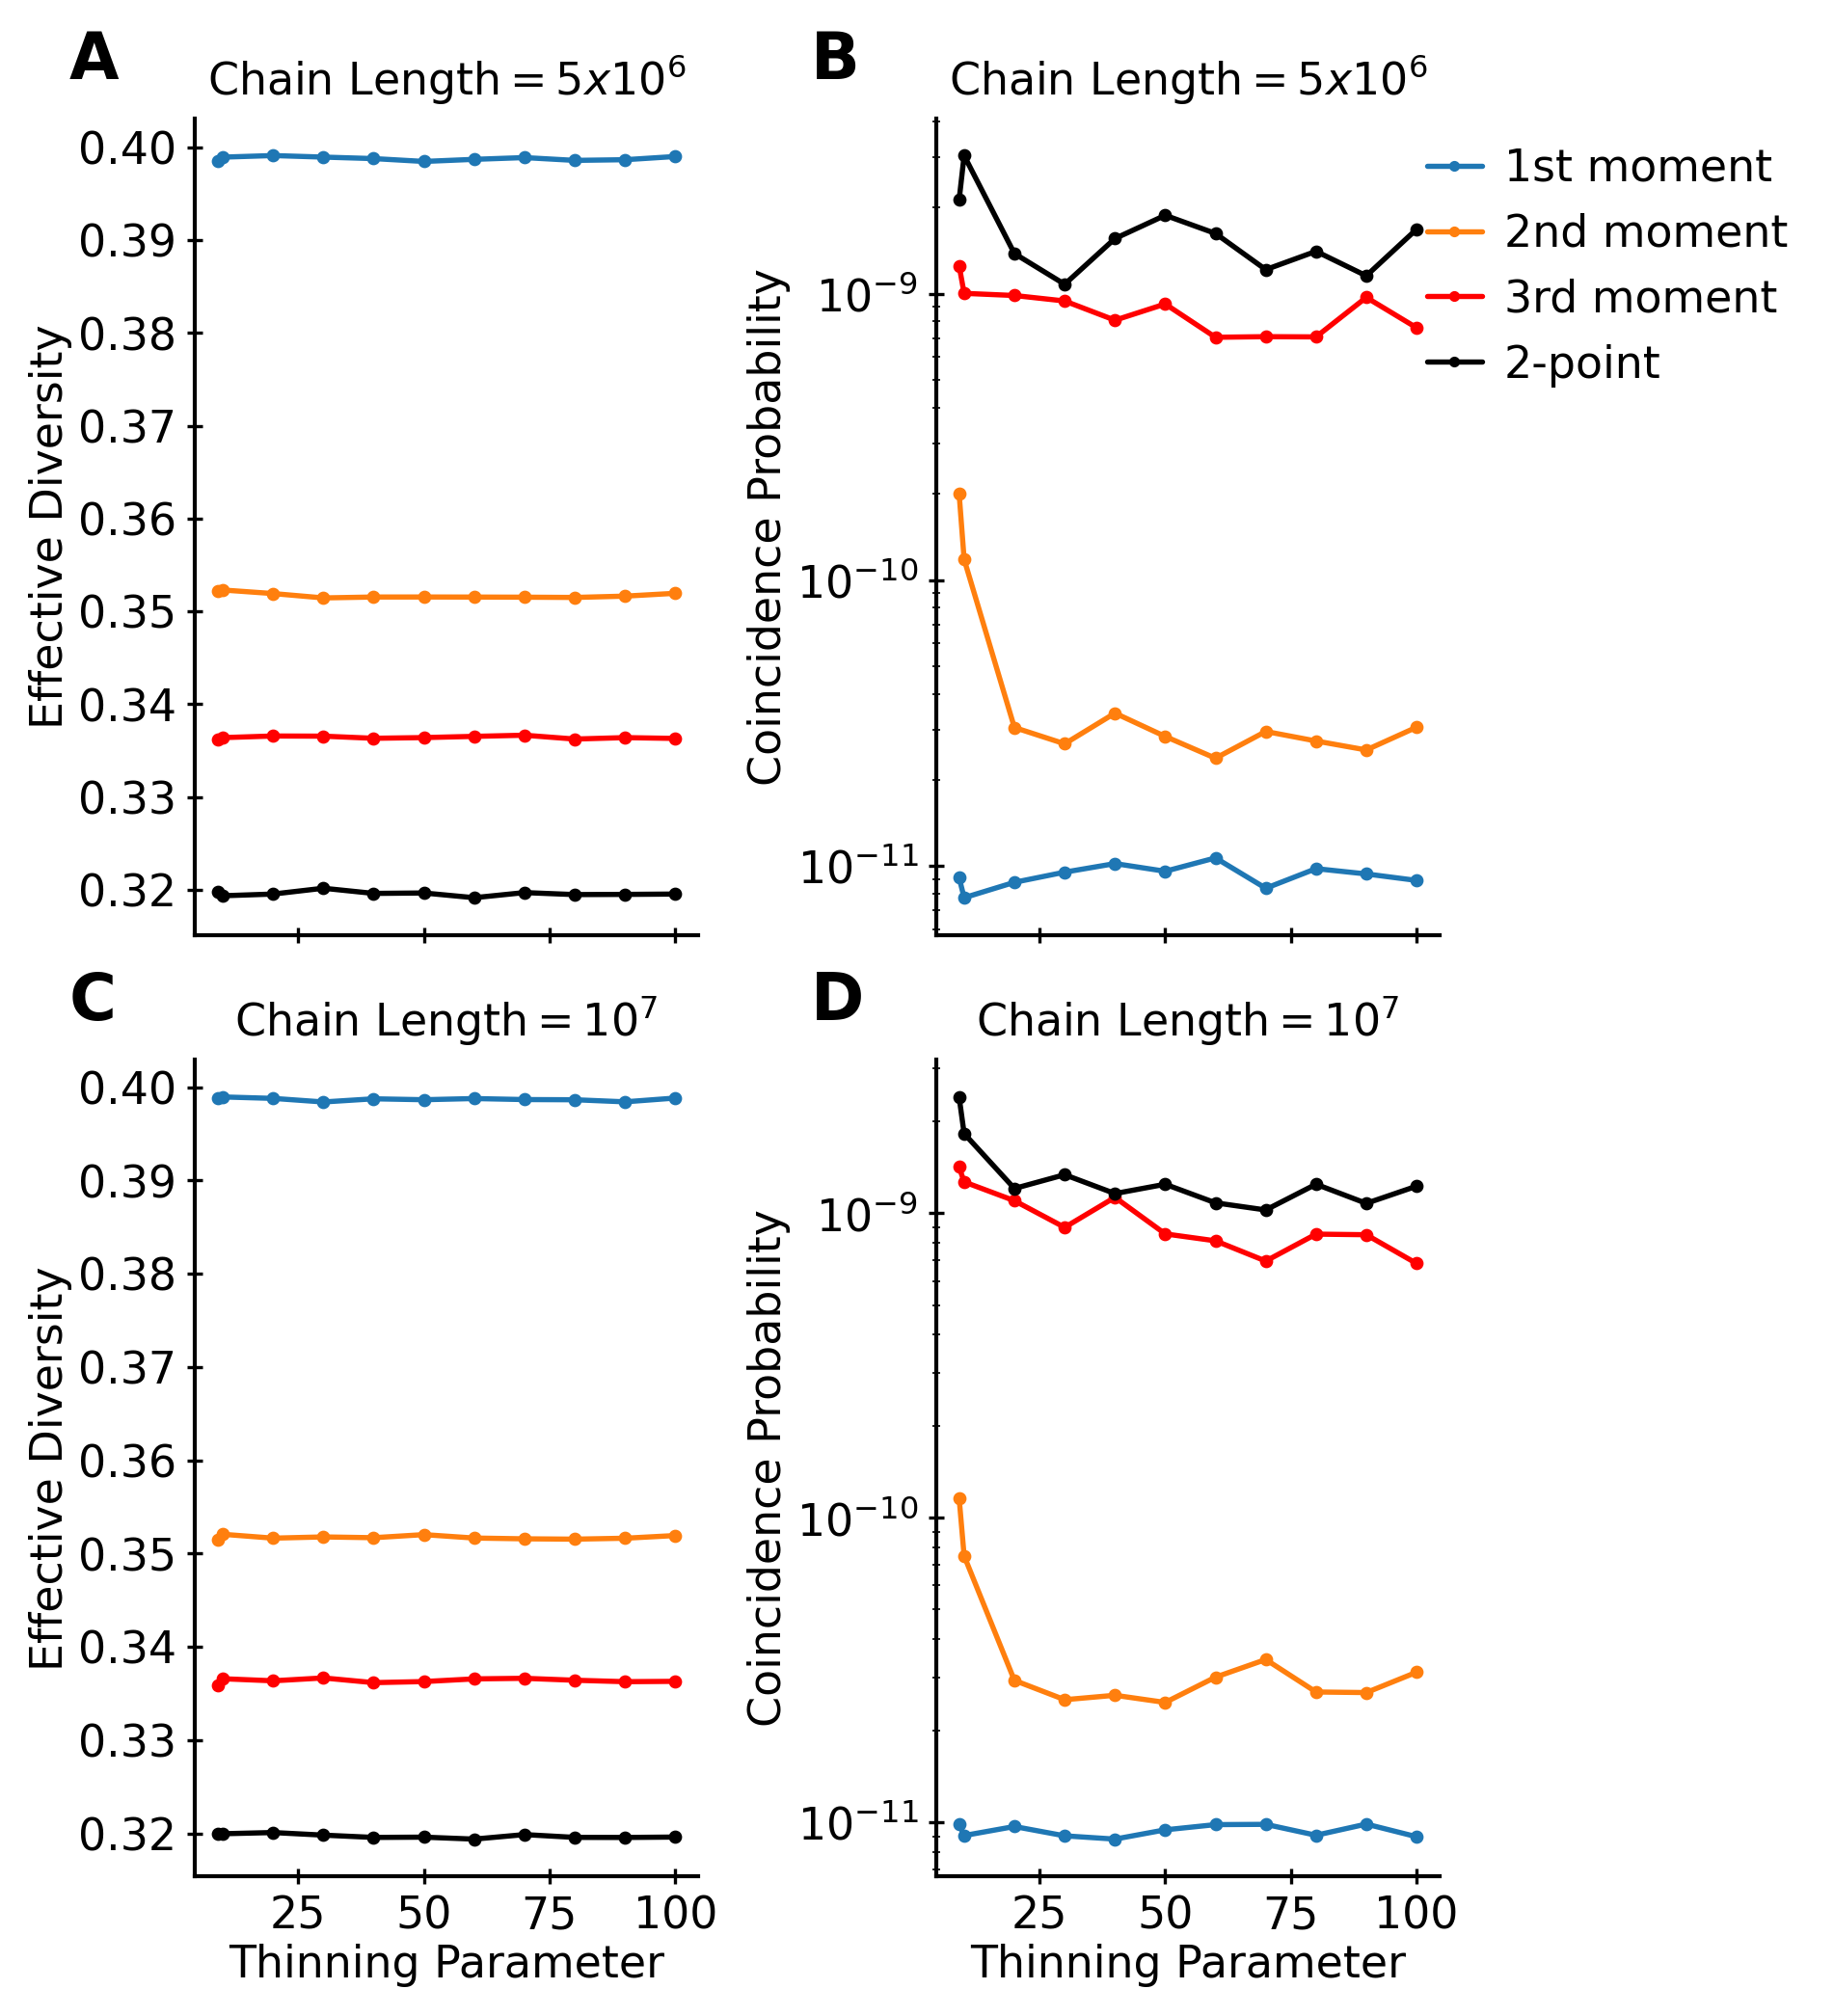

In [8]:
fig, axes = plt.subplots(figsize=(7, 7), ncols=2, nrows=2,sharex=True)


ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]
axfontsize = 11


NSTEPS = ["$=5x10^6$","$=10^7$"]

for model in models:
    vals = list(s_data_small[model].values())
    
    ax1.plot(s_data_small[model].keys(), np.exp(vals)/20**k, '-o', color=color_mapper[model], label=model_mapper[model])
ax1.set_ylabel('Effective Diversity',fontsize=axfontsize)

# ax1.set_xlabel('Thinning Parameter')
ax1.set_title(f'Chain Length{NSTEPS[0]}',fontsize=axfontsize)

for model in models:
    vals = list(pc_data_small[model].values())
    
    ax2.plot(pc_data_small[model].keys(), vals, '-o',color=color_mapper[model], label=model_mapper[model])
ax2.set_yscale('log')
ax2.set_ylabel('Coincidence Probability',fontsize=axfontsize)
# ax2.set_xlabel('Thinning Parameter')
ax2.set_title(f'Chain Length{NSTEPS[0]}',fontsize=axfontsize)


for model in models:
    vals = list(s_data_large[model].values())
    
    ax3.plot(s_data_large[model].keys(), np.exp(vals)/20**k, '-o', color=color_mapper[model], label=model_mapper[model])
ax3.set_ylabel('Effective Diversity',fontsize=axfontsize)
ax3.set_xlabel('Thinning Parameter',fontsize=axfontsize)
ax3.set_title(f'Chain Length{NSTEPS[1]}',fontsize=axfontsize)

for model in models:
    vals = list(pc_data_large[model].values())
    
    ax4.plot(pc_data_large[model].keys(), vals, '-o',color=color_mapper[model], label=model_mapper[model])
ax4.set_yscale('log')
ax4.set_ylabel('Coincidence Probability',fontsize=axfontsize)
ax4.set_xlabel('Thinning Parameter',fontsize=axfontsize)
ax4.set_title(f'Chain Length{NSTEPS[1]}',fontsize=axfontsize)


for ax in [ax1,ax2,ax3,ax4]:
    ax.yaxis.set_tick_params(labelsize=axfontsize)
for ax in [ax3,ax4]:
    ax.xaxis.set_tick_params(labelsize=axfontsize)

    
ax2.legend(loc='upper right',bbox_to_anchor=(1.75,1),fontsize=axfontsize)

    
label_axes(fig,labelstyle='%s', xy=(-0.25, 1.11),fontsize=16)


fig.tight_layout()

# plt.savefig('../figs4.png')
# plt.savefig('../figs4.svg')

